In [1]:
import astropy.units as u
import numpy as np 
import os, sys
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from pprint import pprint
from glob import glob

from syotools.models import Telescope, Camera
from syotools.utils.jsonunit import str_jsunit
from syotools.spectra import SpectralLibrary

Warning, 5 of 20000 bins contained negative fluxes; they have been set to zero.


/data/bwedig/.conda/envs/hwo/lib/python3.10/site-packages/pysynphot/units.py:824: RuntimeWarning: divide by zero encountered in log
  return -1.085736 * N.log(arg) + ABZERO


Warning, 3590 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 293 of 2920 bins contained negative fluxes; they have been set to zero.


# How detectable counts change when varying telescope parameters

parameters to vary:
* aperture size
* exposure time

SEDs (templates): elliptical galaxy for red deflectors (`elliptical`), sbc galaxy for blue sources (`sbc`)

In [37]:
df = pd.read_csv('hwo_lens_population.csv')

band = 'r'

source_redshifts = df.loc[:,'z_source']
lens_redshifts = df.loc[:,'z_lens']
stellar_masses = df.loc[:,'stellar_mass']
einstein_radii = df.loc[:,'einstein_radius']
velocity_dispersions = df.loc[:,'velocity_dispersion']
source_mags = df.loc[:,f'source_mag_{band}']
lensed_source_mags = df.loc[:,f'lensed_source_mag_{band}']
lens_mags = df.loc[:,f'lens_mag_{band}']

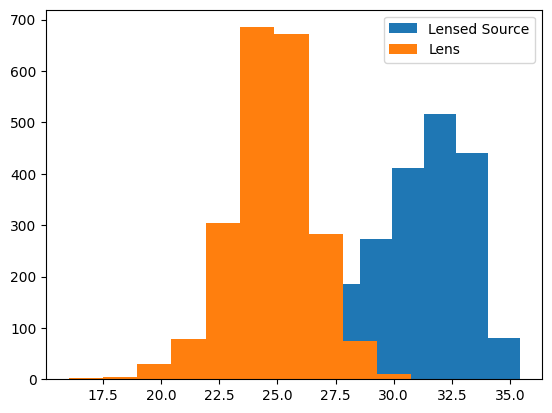

In [38]:
plt.hist(source_lensed_mags, label='Lensed Source')
plt.hist(lens_mags, label='Lens')
plt.legend()
plt.show()

In [23]:
hri, tel = Camera(), Telescope() 
tel.set_from_json('EAC1')
tel.add_camera(hri)
hri_exp = hri.create_exposure()

Setting Telescope to:  EAC1


In [24]:
hri.bandnames

['FUV', 'NUV', 'U', 'B', 'V', 'R', 'I', 'J', 'H', 'K']

Loop through lens galaxies

In [46]:
# set exposure time
exptime = 1  # hours
hri_exp.exptime[1]['value'] = [exptime for _ in hri.bandnames] 

# set SED template for lensing galaxies
hri_exp.sed_id = 'elliptical'

print(hri_exp.magnitude)

# snrs = []
# for mag in tqdm(lens_mags[:100]):
#     hri_exp.magnitude(mag)

#     snr = hri_exp.recover('snr')
#     hri_exp.enable()

#     hri_sed, hri_snr = hri_exp.recover('sed', 'snr')  
#     snr = hri_exp.snr[1]['value']
#     snrs.append(snr)

# lens_snrs = pd.DataFrame(snrs, columns=hri.bandnames)

('JsonUnit', {'unit': 'mag(AB)', 'value': [28.41727600984529, 28.894094473115395, 26.72110238574188, 24.314496342822544, 23.61451038973447, 23.14511705787978, 23.004846108944356, 22.370953569519408, 22.111580024588584, 21.755997612160805]})


Loop through source galaxies

In [42]:
# set exposure time
exptime = 1  # hours
hri_exp.exptime[1]['value'] = [exptime for _ in hri.bandnames] 

# set SED template for source galaxies
hri_exp.sed_id = 'sbc'

snrs = []
for mag in tqdm(source_lensed_mags[:100]):
    hri_exp.renorm_sed(mag * u.ABmag, bandpass='v')

    snr = hri_exp.recover('snr')
    hri_exp.enable()

    hri_sed, hri_snr = hri_exp.recover('sed', 'snr')  
    snr = hri_exp.snr[1]['value']
    snrs.append(snr)

source_snrs = pd.DataFrame(snrs, columns=hri.bandnames)

100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


In [43]:
source_snrs

,FUV,NUV,U,B,V,R,I,J,H,K
0,0.839480,1.943163,10.527417,7.886043,7.620223,7.731735,5.725694,16.822765,17.334624,1.397928
1,0.628554,1.459823,8.083086,6.008225,5.785627,5.845830,4.314482,12.847522,13.189175,1.044114
2,0.495582,1.153458,6.479781,4.791166,4.603018,4.638149,3.415643,10.261506,10.508049,0.821953
3,1.002833,2.315312,12.344648,9.298809,9.008111,9.168203,6.806691,19.802401,20.460072,1.673135
4,0.049690,0.116498,0.690237,0.500140,0.476408,0.475294,0.347307,1.077680,1.093242,0.081986
...,...,...,...,...,...,...,...,...,...,...
95,0.630172,1.463544,8.102290,6.022875,5.799893,5.860437,4.325377,12.878602,13.221474,1.046822
96,0.060361,0.141492,0.837175,0.606936,0.578264,0.577058,0.421750,1.307592,1.326799,0.099605
97,0.003921,0.009199,0.054828,0.039635,0.037719,0.037589,0.027444,0.085463,0.086605,0.006466
98,0.013141,0.030828,0.183515,0.132726,0.126332,0.125927,0.091956,0.286149,0.290035,0.021673


In [33]:
lens_r_snrs = lens_snrs['R']
source_u_snrs = source_snrs['V']

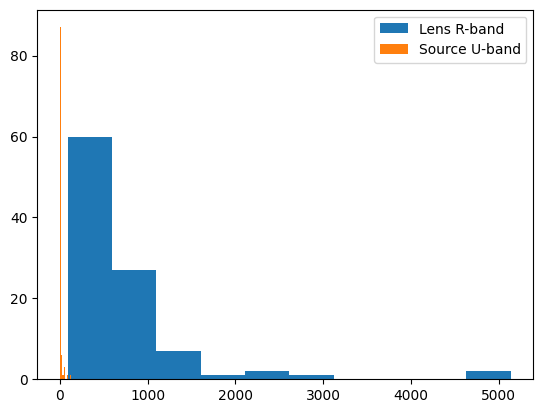

In [34]:
plt.hist(lens_r_snrs, label='Lens R-band')
plt.hist(source_u_snrs, label='Source U-band')
plt.legend()
plt.show()